# Tutorial 5. Building Recommendation Engines

In this notebook we will cover the following:

1. [Building machine learning pipelines](#pipelines)
2. [Finding the nearest neighbors](#neighbor)
3. [Constructing a k-nearest neighbors classifier](#knnc)
4. [Constructing a k-nearest neighbors regressor](#knnr)
5. [Computing the Euclidean distance score](#euclidean)
6. [Computing the Pearson correlation score](#pearson)
7. [Finding similar users in the dataset](#similar)
8. [Generating movie recommendations](#movies)

A recommendation engine is a model that can predict what a user may be interested in. If you have a massive catalog, then users may or may not find all the content that is of interest to them easily. Through recommendation companies can increase consumption. 

Recommendation engines produce a set of recommendations using either collaborative filtering or content-based filtering. Collaborative filtering builds a model from the past behavior of the user as well as ratings given by other users, and then use the model to predict what the user might be interested in. Content-based filtering uses the characteristics of the item itself in order to recommend more items to the user. In this notebook we will focus on collaborative filtering.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

## 5.1 Building machine learning pipelines <a class="anchor" id="pipelines"></a>

The sklearn library has provisions to build machine learning pipelines. Just need to specify the functions, and it will build a composed object that makes the data go through the whole pipeline. The pipeline can include functions, such as preprocessing, feature selection, supervised learning, etc. 

In this example we will build a pipeline to take input feature vector, slect for top *k* features, and then classify using random forest classifier.

In [2]:
from sklearn.datasets import samples_generator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Generate sample data
X,y = samples_generator.make_classification(n_informative=4,n_features=20,
                                           n_redundant=0,random_state=5)
X = pd.DataFrame(X); y = pd.DataFrame(y)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.713576,1.439197,-0.520948,-0.713714,0.344009,0.485706,0.400112,-1.190726,-1.539913,-2.014251,2.290371,-0.340784,1.474930,-1.585158,1.171786,1.151755,0.292251,0.274904,0.514694,2.039680
1,-1.064889,-0.393262,-0.910414,0.170676,0.460912,0.099957,0.905942,0.008978,-0.174598,-1.592487,1.084500,-0.638209,-0.416705,-1.266994,-1.007282,-2.003490,1.399173,0.046372,-0.286616,0.695744
2,-0.898202,0.010480,-0.875772,2.102937,-0.389200,-0.166459,-1.828210,-0.370173,0.418565,1.918689,0.240772,-0.647067,1.527212,-1.999533,-1.683216,0.904898,1.436084,-0.863161,1.546197,-1.784068
3,0.476545,0.245169,-1.141151,-2.673577,-1.025233,0.387235,-1.920168,-1.121378,-0.317466,-1.099295,-0.989888,0.847119,-0.720615,-1.142787,1.160186,1.279623,-0.857703,0.338095,-0.975597,0.513788
4,-0.887151,-0.842608,-1.709142,-1.069628,-0.745772,-1.097347,-0.110912,2.763106,-0.718625,0.139889,-0.126145,-0.025445,0.855455,0.190808,0.770156,-1.453555,-1.032089,-1.398897,2.105889,0.316453


First step is to select the *k* best features before the data is used further. In this case let's use *k*=10. The univariate statistical test we're using for the selector is *f_classif* which computes the ANOVA F-value for the provided sample. There are other selectors you can use for both regression and classification, can see them [here](http://scikit-learn.org/stable/modules/feature_selection.html):

In [3]:
# Feature selector
selector_k_best = SelectKBest(f_classif,k=10)

Next step is to use random forest classifier to classify the data

In [4]:
#Random Forest classifier
clf = RandomForestClassifier(n_estimators=50,max_depth=4)

### Build the pipeline

We can assign names to the blocks of the pipeline, for example below we assign *selector* and *rf* to feature selector and random forest classifier.

In [5]:
pipe = Pipeline([('selector',selector_k_best),('rf',clf)])

We can also update the parameters in the future, by using the names we assigned in the last step. For example, if we want to set *k* to 6 instead of 10, and *n_estimators* to 25 instead of 50, we can do it as follows:

In [6]:
pipe.set_params(selector__k=6,rf__n_estimators=25)

Pipeline(steps=[('selector', SelectKBest(k=6, score_func=<function f_classif at 0x10fc43b70>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

### Train the classifier

In [7]:
pipe.fit(X,y[0])

Pipeline(steps=[('selector', SelectKBest(k=6, score_func=<function f_classif at 0x10fc43b70>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

Predict outputs for the training data and estimate it's performance:

In [8]:
ypred = pipe.predict(X)
score = pipe.score(X,y[0])
print('Score of classifier: ',score)

Score of classifier:  0.94


Now let's see which features were selected:

In [9]:
features_status = pipe.named_steps['selector'].get_support()
features = np.arange(1,21)
print('Features selected: ',features[features_status])

Features selected:  [ 1  6 10 11 12 16]


Can see above that 6 features were selected as prescribed. The advantage of using *k* best features is that it can work with low-dimensional data to help reduce the computational complexity. The way the *k* features are selected is based on univariate feature selection, where it performs univariate statistical tests (1 variable invloved) and then extracts the top-performing features from the feature vector.

When these tests are performed each feature is assigned a score - based on the scores we select the *k* best features.

You can also use the pipeline created on test data, and it will take the same features.

## 5.2 Finding the nearest neighbors <a class="anchor" id="neighbor"></a>

Nearest neighbors is a model that refers to a general class of algorithms that aim to make a decision based o the number of nearest neighbors in the training dataset.

We will create data to use for this example:

In [10]:
from sklearn.neighbors import NearestNeighbors

X = pd.DataFrame( np.array([[1,1],[1,3],[2,2],[2.5,5],[3,1],[4,2],[2.,3.5],
                            [3,3],[3.5,4] ]),columns=['x1','x2'])
X.head()

,x1,x2
0,1.0,1.0
1,1.0,3.0
2,2.0,2.0
3,2.5,5.0
4,3.0,1.0


Goal is to find the 3 closest neighbors to any given point:

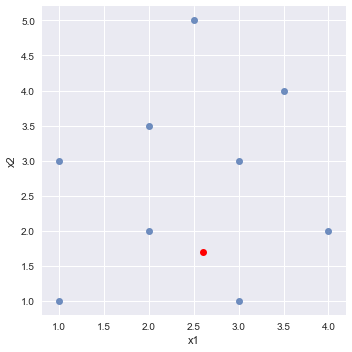

In [11]:
# Number of neighbors wanted
num_neighbors= 3

# Input data point not present in X
input=[2.6,1.7]

# Plot scatter
sns.lmplot(x='x1',y='x2',data=X,fit_reg=False)
plt.plot(input[0],input[1],'ro')

The red dot above is the input point we want to find the closest neighbors to.

### Build nearest neighbors model

In [12]:
knn = NearestNeighbors(n_neighbors=num_neighbors,algorithm='ball_tree').fit(X)

#Find distances of input to all points
distances,indices = knn.kneighbors(input)
print( indices)
print('The k-nearest neighbors are as follows:')
knnX = X.iloc[indices[0]]
knnX.head()

[[2 4 7]]
The k-nearest neighbors are as follows:


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


,x1,x2
2,2.0,2.0
4,3.0,1.0
7,3.0,3.0


Make plot of the nearest neighbors:

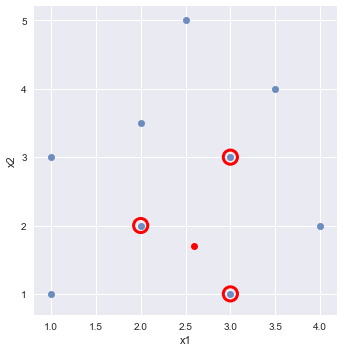

In [13]:
sns.lmplot(x='x1',y='x2',data=X,fit_reg=False)
plt.plot(input[0],input[1],'ro')
plt.scatter(knnX.x1,knnX.x2,marker='o',s=200,color='r',facecolors='none',linewidth=3.0)

## 5.3 Constructing a k-nearest neighbors classifier <a class="anchor" id="knnc"></a>

The **k-nearest neighbors** classifier uses the *k*-nearest neighbors in the training dataset to find the class of an unknown object. To find the class to which an unknown datapoint belongs to, we find the *k*-nearest neighbors and then take a majority vote.

In this example we will use the *data_nn_classifier.txt* file.

#### How does it work?
The *k*-nearest neighbors classifier stores all the available datapoints and classifies new datapoints based on a similarity metric. This metric usually is in the form of a distance function. The algorithm is a non-parametric technique, which means it doesn't need to find any underlying parameters, and all you need is a *k* value. Once the *k* neighbors are found, a majority vote is taken for classification.


,x1,x2,y
0,1.82,2.04,0
1,3.31,6.78,1
2,6.33,2.55,2
3,2.05,2.47,0
4,4.30,5.25,1


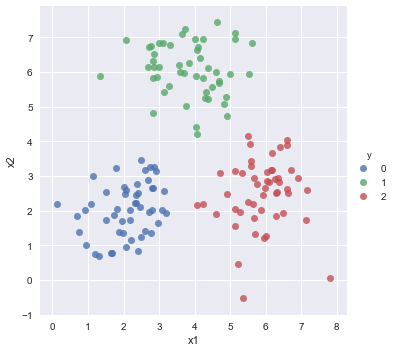

In [14]:
from sklearn import neighbors,datasets
data = pd.read_csv('data_nn_classifier.txt',names=['x1','x2','y'])
display( data.head() )
sns.lmplot(data=data,x='x1',y='x2',hue='y',fit_reg=False)

Can see that the classes are clearly clustered into 3 groups above.

### Build classifier

In [15]:
from sklearn.model_selection import train_test_split
# Number of nearest neighbors to consider
n_neighbors = 10

# To visualize boundaries, need a grid size 
h = 0.01

# KNN Classifier model and train
train,test = train_test_split(data,test_size=0.1, random_state=42)
Xtrain = train.drop(['y'],axis=1); ytrain=train.y
Xtest  = test.drop(['y'],axis=1); ytest = test.y
clf = neighbors.KNeighborsClassifier(n_neighbors,weights='distance')
clf.fit(Xtrain,ytrain)

ypred_test = clf.predict(Xtest)
ypred_train= clf.predict(Xtrain)
#Creat meshgrid to evaluate classifier at training points
x1max,x2max = Xtrain.max()
x1min,x2min = Xtrain.min()
x1grid,x2grid = np.meshgrid(np.arange(x1min,x1max,h),np.arange(x2min,x2max,h))
output = clf.predict(np.c_[x1grid.ravel(),x2grid.ravel()])
output = output.reshape(x1grid.shape)

Make plots of boundaries and plot training points:

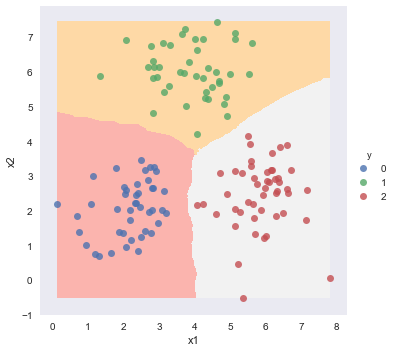

In [16]:
plt.figure()
sns.lmplot(data=train,x='x1',y='x2',hue='y',fit_reg=False)
plt.pcolormesh(x1grid,x2grid,output,cmap=matplotlib.cm.Pastel1,zorder=0)

Use test datapoints as test with the same boundary:

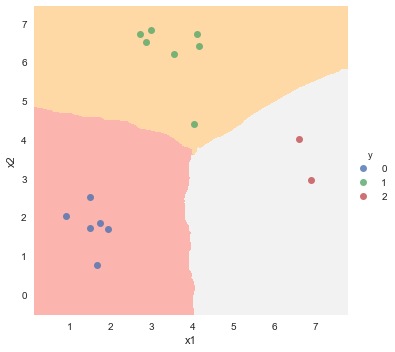

In [17]:
plt.figure()
sns.lmplot(data=test,x='x1',y='x2',hue='y',fit_reg=False)
plt.pcolormesh(x1grid,x2grid,output,cmap=matplotlib.cm.Pastel1,zorder=0)

Can see from the above that all of the test datapoints were correctly classified. Let's add on to the previous plot and also show the 10 nearest neighbors for all the test points.

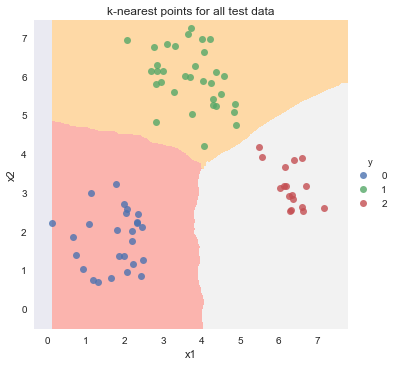

In [18]:
distances, indices = clf.kneighbors(Xtest)
neighborpoints = train.iloc[np.unique(indices.ravel())]
sns.lmplot(data=neighborpoints,x='x1',y='x2',hue='y',fit_reg=False)
plt.pcolormesh(x1grid,x2grid,output,cmap=matplotlib.cm.Pastel1,zorder=0)
plt.title('k-nearest points for all test data')

Now look at test classification report:

In [19]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(ytest,ypred_test,target_names=['class0','class1','class2']))
print('\nAccuracy score: ',accuracy_score(ytrain,ypred_train))

             precision    recall  f1-score   support

     class0       1.00      1.00      1.00         6
     class1       1.00      1.00      1.00         7
     class2       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        15


Accuracy score:  1.0


## 5.4 Constructing a k-nearest neighbors regressor <a class="anchor" id="knnr"></a>

We can use the same k-nearest neighbor algorithm to build a regressor. We will create test data to use for this example.

#### How does it work?
The regressor is similar to the classifier, but except for majority vote, when estimating a new datapoint the *k* nearest neighbors are found and  the value is the average of the values of its *k* nearest neighbors.

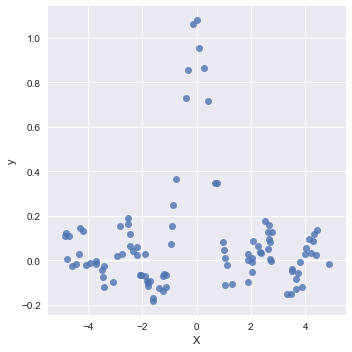

In [20]:
#Generate data
amplitude = 10.; num_points=100
X = amplitude*np.random.rand(num_points,1)-0.5*amplitude

#Target and add noise
y = np.sinc(X).ravel(); y+=0.2*(0.5 - np.random.rand(y.size))
X.shape
y.shape
data = pd.DataFrame({'X':X.ravel(),'y':y})

#Visualize
sns.lmplot(data=data,x='X',y='y',fit_reg=False)

Make grid to evaluate near-continuous function:

In [21]:
xgrid = np.linspace(-0.5*amplitude,0.5*amplitude,10*num_points)[:,np.newaxis]

### Build KNN regressor model

In [22]:
n_neighbors=8

# Model
knn_regressor = neighbors.KNeighborsRegressor(n_neighbors,weights='distance')

#Train
knn_regressor.fit(X,y)

#Predict
yvals = knn_regressor.predict(xgrid)

Make plot to see how well it does:

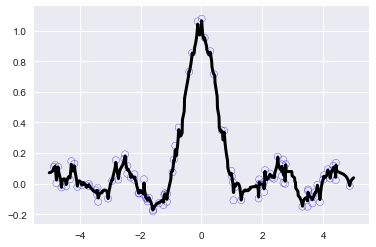

In [23]:
plt.figure()
plt.scatter(X,y,marker='o',facecolors='none',edgecolors='b',s=50)
plt.plot(xgrid,yvals,'k',linewidth=3.0)

## 5.5 Computing the Euclidean distance score <a class="anchor" id="euclidean"></a>

In order to build a recommendation engine, we need to define a similarity metric so that we can find users in the database who are similar to a given user. **Euclidean distance score** is one metric we can use to compute distance between datapoints. 

We will use the *movie_ratings.json* file as the data file. It contains names of users and ratings for different movies.

In [24]:
ratingsdf = pd.read_json('movie_ratings.json')
ratingsdf.head(10)

,Alex Roberts,Jillian Hobart,John Carson,Melissa Jones,Michael Henry,Michelle Peterson,William Reynolds
Anger Management,NaN,3.0,3.0,2,NaN,1.5,NaN
Fracture,5.0,4.0,3.5,3,4.0,5.0,3.5
Inception,3.0,NaN,2.5,3,NaN,3.0,2.5
Jerry Maguire,3.0,4.5,3.0,3,NaN,3.0,4.0
Pulp Fiction,4.0,3.5,3.5,4,4.5,3.5,3.0
Serendipity,3.5,2.5,2.5,2,1.0,3.5,NaN


Can see above that users are the columns and the movies are the rows, movies without ratings are listed as NaN.

Next we compute the euclidean distance, if the ratings are similar then the sum of squared differences will be very low and the score will be high.

In [25]:
def euclidean_score(dataset,user1,user2):
    # Check to make sure both users in dataset
    if not (user1 in dataset.columns and user2 in dataset.columns):
        raise TypeError('Either user1 or user2 is not present in dataset')
    # Find movies rate by both user1 and user2
    shared_movies = dataset.index[ (dataset[user1].notnull()) &(dataset[user1].notnull()) ]
    # If no shared movies then no similarity
    if len(shared_movies) == 0:
        return 0
    # For each common ratings, we compute the square root of the sum of  the
    # squared differences and normalize so score is between 0 and 1
    scores = dataset.ix[shared_movies][[user1,user2]]
    display(scores.head())
    SSE = np.sum( np.diff(scores.values,axis=1)**2 )
    return 1./(1+np.sqrt(SSE))

In [26]:
# Calculate euclidean distance for two users
user1='John Carson'
user2='Michelle Peterson'
print('Euclidean score: ', euclidean_score(ratingsdf,user1,user2))

,John Carson,Michelle Peterson
Anger Management,3.0,1.5
Fracture,3.5,5.0
Inception,2.5,3.0
Jerry Maguire,3.0,3.0
Pulp Fiction,3.5,3.5


Euclidean score:  0.294298055086


The higher the score the more similar the users movie ratings are.

## 5.6 Computing the Pearson correlation score <a class="anchor" id="pearson"></a>

The Euclidean distance score is a good metric, but has shortcomings especially if the scale between the objects is much different. This is why Pearson correlation score is frequently used in recommendation engines.

The goal of the below example is to use the same movie ratings data to find users who are similar to eachother.

In [27]:
ratingsdf = pd.read_json('movie_ratings.json')

Below we calculate Pearson correlation coefficient for two different users movie ratings:

### Pearson Score

In [28]:
# Returns the Pearson correlation score between user1 and user2 
def pearson_score(dataset, user1, user2,ret_share=False):
    # Check to make sure both users in dataset
    if not (user1 in dataset.columns and user2 in dataset.columns):
        raise TypeError('Either user1 or user2 is not present in dataset')
    # Find movies rate by both user1 and user2
    shared_movies = dataset.loc[(dataset[user1].notnull()) & (dataset[user2].notnull())].index.values

    # If no shared movies then no similarity
    if len(shared_movies) == 0:
        return 0
    
    num_ratings = len(shared_movies)
    scores = dataset.ix[shared_movies][[user1,user2]]
    
    # Compute the sum of ratings of all the common preferences 
    user1_sum = np.sum(scores[user1],axis=0)
    user2_sum = np.sum(scores[user2],axis=0)
    
    # Compute the sum of squared ratings of all the common preferences 
    user1_squared_sum = np.sum(np.square(scores[user1]),axis=0)
    user2_squared_sum = np.sum(np.square(scores[user2]),axis=0)
    
    # Compute the sum of products of the common ratings 
    product_sum = np.sum(scores[user1]*scores[user2],axis=0)
    
    # Compute the Pearson correlation
    Sxy = product_sum - (user1_sum * user2_sum / num_ratings)
    Sxx = user1_squared_sum - np.square(user1_sum)/ num_ratings
    Syy = user2_squared_sum - np.square(user2_sum)/ num_ratings
    
    # Return shared movies if wanted along with Pearson score
    if ret_share:
        if Sxx * Syy == 0:
            return 0, shared_movies
        return Sxy / np.sqrt(Sxx * Syy), shared_movies
    else:
        if Sxx * Syy == 0:
            return 0
        return Sxy / np.sqrt(Sxx * Syy)

In [29]:
# Calculate pearson distance for two users
user1='William Reynolds'
user2='Michael Henry'
display( ratingsdf[[user1,user2]].head(10) )
print('Pearson correlation score: ', pearson_score(ratingsdf,user1,user2))

,William Reynolds,Michael Henry
Anger Management,NaN,NaN
Fracture,3.5,4.0
Inception,2.5,NaN
Jerry Maguire,4.0,NaN
Pulp Fiction,3.0,4.5
Serendipity,NaN,1.0


Pearson correlation score:  -1.0


## 5.7 Finding similar users in the dataset <a class="anchor" id="similar"></a>

One of the most important tasks in building recommendation engine is finding users that are similar. We will use the movie ratings dataset and the Pearson Score in the last section.

Below we have a function that takes a given user and then finds the top *k* other users that are similar to the input user:

In [30]:
# Finds a specified number of users who are similar to the input user
def find_similar_users(dataset,user,num_users):
    if not (user in dataset.columns):
        raise TypeError('User is not present in dataset')
    # Compute Pearson scores for all users 
    allusers = dataset.drop([user],axis=1).columns
    allusers = allusers.values
    pearson = []; shared_movies = []
    for user2 in allusers:
        ps,sm = pearson_score(dataset,user,user2,ret_share=True)
        pearson.append(ps);shared_movies.append(sm)
    scores = pd.DataFrame({'users':allusers,'scores':pearson,'sharemovs':shared_movies}).sort_values(by='scores',ascending=False)
    # If num_users is not 'all' grab the top k scores
    if num_users is not 'all':
        scores = scores[:num_users]
    return scores

### Finding similar users 

Now we want to find 3 similar users to 'John Carson', it also displays the shared movies in one column:

In [31]:
user='John Carson'
scores = find_similar_users(ratingsdf,user,3)
print('Top 3 users similar to ', user)
scores.head()

Top 3 users similar to  John Carson


,scores,sharemovs,users
3,0.991241,"[Fracture, Pulp Fiction, Serendipity]",Michael Henry
0,0.747018,"[Fracture, Inception, Jerry Maguire, Pulp Fict...",Alex Roberts
2,0.594089,"[Anger Management, Fracture, Inception, Jerry ...",Melissa Jones


## 5.8 Generating movie recommendations <a class="anchor" id="movies"></a>

Now that we have built all the different parts, we can generate movie recommendations. 

Define a function to generate movie recommendations for a given user. It uses the similarity (Pearson score) to weight movie ratings from users for movies a given user has not seen.

In [32]:
# Generate movie recommendations for a user
def generate_recommendations(dataset,user):
    # Make sure user is in dataset
    if not (user in dataset.columns):
        raise TypeError('User is not present in dataset')
    # Find Pearson scores of user with all other users
    scores = find_similar_users(dataset,user,num_users='all')
    # Find which movies user has not rated
    unseenmovs = dataset.loc[dataset[user].isnull() ].index.values
    if len(unseenmovs) == 0:
        raise TypeError('User has seen all movies, no recommendation possible')
    
    # Use Pearson (Similarity Score) to multiply the ranked choices for each user
    # Create ranking dataset from movies
    rankDF = pd.DataFrame(data=0, columns=['total_score','similarity_sums'],index=unseenmovs)
    # Multiply dataset through by scores
    #Remove users with similarity <=0 
    scores = scores.ix[scores.scores>0]
    weightdata = dataset.loc[unseenmovs,scores.users]
    for user2 in scores.users: weightdata[user2] = weightdata[user2] * scores.loc[scores.users==user2,'scores'].values[0]
    for movie in unseenmovs:        
        rankDF.ix[movie,'total_score']     = weightdata.ix[movie].sum()
        users2drop =  weightdata.ix[movie].isnull().values
        rankDF.ix[movie,'similarity_sums'] = scores.ix[~users2drop,:].scores.sum()
    rankDF['score'] = rankDF.total_score/rankDF.similarity_sums
    
    return rankDF.sort_values(by='score',ascending=False).score 

In [33]:
print('Recommendations for Michael Henry:\n',generate_recommendations(ratingsdf,'Michael Henry'))

Recommendations for Michael Henry:
 Jerry Maguire       3.347790
Inception           2.832550
Anger Management    2.530981
Name: score, dtype: float64
